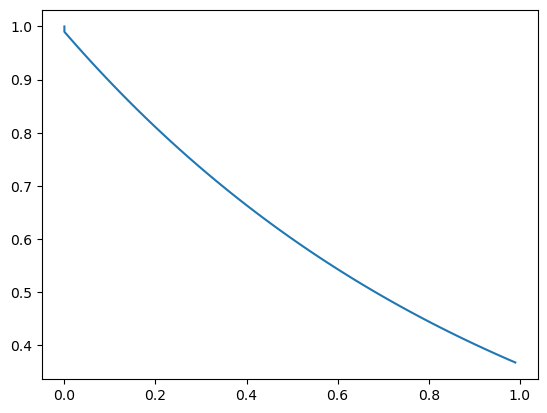

In [34]:
import generalised_lotka_volterra as glv
import numpy as np
from scipy.integrate import RK45
from scipy.integrate._ivp.rk import rk_step
import matplotlib.pyplot as plt

def _rk_step(RKSolver, dt):
    '''
    wraps the rk_step function to take an RKSolver object as an argument
    '''
    return rk_step(RKSolver.fun, RKSolver.t, RKSolver.y, RKSolver.f, dt, RKSolver.A, RKSolver.B, RKSolver.C, RKSolver.K)

def test_ode(t, y):
    return -y

solver = RK45(test_ode, 0, [1], np.inf, rtol=1e-5)

y = [1.0]
t = [0.0]

for _ in range(100):
    dt = 0.01
    y.append(_rk_step(solver, dt)[0][0])
    t.append(solver.t)
    y_new, f_new = _rk_step(solver, dt)
    solver.y = y_new
    solver.t += dt
    solver.f = f_new

plt.plot(t, y)




In [ ]:
from scipy.integrate import solve_ivp
from collections import deque
import plotly.graph_objects as go
import numpy as np

def update_buffers(new_t0_index: int, starting_integration_index: int, t: deque, y: deque, fun, alpha: np.ndarray, dt: float):
    '''
    updates the buffer so that t[new_t0_index] -> t[0] 
    and re-integrates the buffer from starting_integration_index to the end of the buffer
    '''

    t.rotate(-new_t0_index)
    y.rotate(-new_t0_index)

    number_of_steps = t.maxlen - starting_integration_index
    sol = solve_ivp(fun, 
                    (t[starting_integration_index], t[starting_integration_index] + number_of_steps*dt), 
                    y[starting_integration_index], 
                    args=(alpha,), 
                    rtol = 1e-5,
                    atol = 1e-8,
                    t_eval=np.linspace(t[starting_integration_index], t[starting_integration_index] + number_of_steps*dt, number_of_steps))
    
    # roll_back so that after appending the new results we still have t[new_t0_index] -> t[0]
    t.rotate(-starting_integration_index)
    y.rotate(-starting_integration_index)

    # append the new results to the end of the buffer
    for t_new, y_new in zip(sol.t, sol.y.T):
        t.append(t_new)
        y.append(y_new)


def fun(t, y, alpha):
    return y*(1 - y + alpha@y)

alpha = np.array([[0, -1], [-1, 0]])

t = deque(maxlen=100)
y = deque(maxlen=100)
display_size = 50
display_window = [23, 32+50]

t0 = 0.0
y0 = [0.5, 1.0]
t.append(t0)
y.append(y0)

t_initial_index = 0
number_of_steps = 100

dt = 0.1
fig = go.Figure()

sol = solve_ivp(fun, (t0, t0 + 200*dt), y0, args=(alpha,), rtol = 1e-5, atol = 1e-8, t_eval=np.linspace(t0, t0 + 200*dt, 200))
for t_new, y_new in zip(sol.t[:100], sol.y.T[:100]):
    t.append(t_new)
    y.append(y_new)

for i in range(2):
    fig.add_trace(go.Scatter(x=np.asarray(t), y=np.array(y)[:,i], mode='lines', showlegend=False))
    fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines', showlegend=False, line=dict(dash='dash')))

# fig.add_shape(type="line", x0=(t_initial_index + number_of_steps)*dt, x1=(t_initial_index + number_of_steps)*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))
# fig.add_shape(type="line", x0=t_initial_index*dt, x1=t_initial_index*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))


integration_index = 67
new_t0_index = 54
relative_integration_index=integration_index-new_t0_index
print(t[integration_index])
print(t[new_t0_index])
print(t[integration_index] + new_t0_index*dt)

alpha = np.array([[0, -2], [1, 0]])

sol = solve_ivp(fun, (t[integration_index], t[integration_index] + (100 - (integration_index - new_t0_index))*dt), sol.y.T[integration_index], args=(alpha,), rtol = 1e-5, atol = 1e-8, t_eval=np.linspace(t[integration_index], t[integration_index] + (100 - (integration_index - new_t0_index))*dt, (100 - (integration_index - new_t0_index))))
update_buffers(new_t0_index, relative_integration_index, t, y, fun, alpha, dt)

# print(sol.t.shape)
# t.rotate(-integration_index)
# y.rotate(-integration_index)
# print(t[-1])

# for t_new, y_new in zip(sol.t, sol.y.T):
#     t.append(t_new)
#     y.append(y_new)

for i in range(2):
    fig.add_trace(go.Scatter(x=np.asarray(t), y=np.array(y)[:,i], mode='lines', showlegend=False))
    fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines', showlegend=False, line=dict(dash='dash', color='black'), zorder=1))

fig.add_shape(type="line", x0=integration_index*dt, x1=integration_index*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))
fig.add_shape(type="line", x0=new_t0_index*dt, x1=new_t0_index*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))
fig.add_shape(type="line", x0=(new_t0_index + 100)*dt, x1=(new_t0_index + 100)*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))
# fig.add_shape(type="line", x0=25*dt, x1=25*dt, y0=0, y1=1, line=dict(color="Black", width=2, dash="dash"))


fig.show()

6.733668341708543
5.42713567839196
12.133668341708542


In [23]:
import plotly.graph_objects as go

import numpy as np
from scipy.integrate import solve_ivp
from collections import deque


def glv(t, y, alpha):
    return y*(1 - y + alpha@y)

def update_buffers(new_t0_index: int, starting_integration_index: int, t: deque, y: deque, fun, alpha: np.ndarray, dt: float):
    '''
    updates the buffer so that t[new_t0_index] -> t[0] 
    and re-integrates the buffer from starting_integration_index to the end of the buffer
    '''

    t.rotate(-new_t0_index)
    y.rotate(-new_t0_index)

    number_of_steps = t.maxlen - starting_integration_index
    sol = solve_ivp(fun, 
                    (t[starting_integration_index], t[starting_integration_index] + number_of_steps*dt), 
                    y[starting_integration_index], 
                    args=(alpha,), 
                    rtol = 1e-5,
                    atol = 1e-8,
                    t_eval=np.linspace(t[starting_integration_index], t[starting_integration_index] + number_of_steps*dt, number_of_steps))
    
    # roll_back so that after appending the new results we still have t[new_t0_index] -> t[0]
    t.rotate(-starting_integration_index)
    y.rotate(-starting_integration_index)

    # append the new results to the end of the buffer
    for t_new, y_new in zip(sol.t, sol.y.T):
        t.append(t_new)
        y.append(y_new)

    # t0_index is now the first index
    return 0, t, y

BUFFER_SIZE = 500
PLOT_WIDTH = 100 # units of dt
REINTEGRATE_THRESHOLD = BUFFER_SIZE - PLOT_WIDTH - 50 # re-integrate when t0 reaches here
t0_index = 0
dt = 0.1 
TIME_STEPS_UNTIL_NEXT_REFRESH = 1



N0 = 2
sigma0 = 1.0
mu0 = 0.0
z0 = np.random.normal(0.0, 1.0, (N0, N0))
alpha0 = mu0/N0 + sigma0*z0/np.sqrt(N0)
t0 = 0.0
y0 = np.random.uniform(0, 1, N0)

t = deque(maxlen=BUFFER_SIZE)
y = deque(maxlen=BUFFER_SIZE)
t.append(t0)
y.append(y0)

# initial integration 
t0_index, t, y = update_buffers(t0_index, 0, t, y, glv, alpha0, dt)

fig = go.Figure()
fig.add_traces([go.Scatter(x=list(t), y=np.asarray(y)[:,i], mode='lines', showlegend=False) for i in range(N0)])

fig.show()

t0_index = 340

t0_index, t, y = update_buffers(t0_index, PLOT_WIDTH + 50, t, y, glv, alpha0, dt)

fig = go.Figure()

fig.add_traces([
    go.Scatter(
    x=list(t), 
    y=np.asarray(y)[:, i], 
    mode='lines', showlegend=False) for i in range(N0)]
)

fig.show()

'''

def update_abundance_plot(n_intervals, abundance_figure, t0_index, N, alpha):
    if t0_index >= REINTEGRATE_THRESHOLD:
        t0_index = update_buffers(t0_index, PLOT_WIDTH + 50, t, y, glv, alpha, dt)

    abundance_figure['data'] = [go.Scatter(
        x=list(t)[t0_index:t0_index + PLOT_WIDTH], 
        y=np.asarray(y)[t0_index:t0_index + PLOT_WIDTH, i], 
        mode='lines', showlegend=False) for i in range(N)]
    
    return abundance_figure, t0_index + TIME_STEPS_UNTIL_NEXT_REFRESH

def re_integrate(alpha, t0_index):
    print(t0_index)
    t0_index = update_buffers(t0_index, 0, t, y, glv, alpha, dt)

    return t0_index
'''

"\n\ndef update_abundance_plot(n_intervals, abundance_figure, t0_index, N, alpha):\n    if t0_index >= REINTEGRATE_THRESHOLD:\n        t0_index = update_buffers(t0_index, PLOT_WIDTH + 50, t, y, glv, alpha, dt)\n\n    abundance_figure['data'] = [go.Scatter(\n        x=list(t)[t0_index:t0_index + PLOT_WIDTH], \n        y=np.asarray(y)[t0_index:t0_index + PLOT_WIDTH, i], \n        mode='lines', showlegend=False) for i in range(N)]\n    \n    return abundance_figure, t0_index + TIME_STEPS_UNTIL_NEXT_REFRESH\n\ndef re_integrate(alpha, t0_index):\n    print(t0_index)\n    t0_index = update_buffers(t0_index, 0, t, y, glv, alpha, dt)\n\n    return t0_index\n"

In [22]:
from scipy.integrate import solve_ivp
import numpy as np
import plotly.graph_objects as go
import numba as nb

@nb.njit
def glv(t, y, alpha):
    N = len(y)
    result = [0.0 for _ in range(N)]
    alpha_times_y = [0.0 for _ in range(N)]

    for i in range(N):
        # for j in range(N):
            # alpha_times_y[i] += alpha[i][j]*y[j]

        # result[i] = y[i]*(1 - y[i] + alpha_times_y[i])
        result[i] = y[i]

    return result

alpha = [[1.0, 2.0], [2.0, 3.0]]
y0 = [1.0, 2.0]
t0 = 0.0



print(glv(t0, y0, alpha))

TypeError: cannot reflect element of reflected container: reflected list(reflected list(float64)<iv=None>)<iv=None>


In [149]:
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

class CircularBuffer: 
    def __init__(self, shape, fill_value=None, **buffer_kwargs): 
        self.shape = shape
        if isinstance(shape, int): 
            self.principal_length = shape
        elif isinstance(shape, tuple): 
            self.principal_length = shape[0]
        else:
            raise ValueError("shape must be an int or a tuple")
            
        self.buffer = np.full(shape, fill_value=fill_value, **buffer_kwargs) 
        self.index = 0 

    def end(self):
        if self.index==-1:
            return self.buffer[-1]
        return self.buffer[self.index - 1]

    def append(self, value): 
        self.buffer[self.index] = value 
        self.index = (self.index + 1) % self.principal_length
        
    def get(self): 
        return np.r_[self.buffer[self.index:], self.buffer[:self.index]]
        # return np.roll(self.buffer, -self.index)
    
    def __repr__(self):
        return str(self.get())
    

def glv(t, y, alpha):
    return y*(1 - y + alpha@y)

N = 10
alpha = np.random.normal(0, 1/np.sqrt(N), (N, N))

t = CircularBuffer(100)
y = CircularBuffer((100, N))

t.append(0.0)
y.append(np.random.uniform(0, 1, N))

# print(t.get())
# print(y.get())

# print(t.end())
# print(y.end())

sol = solve_ivp(glv, (t.end(), 100), y.end(), args=(alpha,), rtol=1e-5, atol=1e-8)

sol_first_half = solve_ivp(glv, (t.end(), t.end() + 25), y.end(), args=(alpha,), rtol=1e-5, atol=1e-8)
# print(sol_first_half.y)

for t_new, y_new in zip(sol_first_half.t, sol_first_half.y.T):
    t.append(t_new)
    y.append(y_new)

fig = go.Figure()
for i in range(N):
    # fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines'))
    fig.add_trace(go.Scatter(x=t.get(), y=y.get()[:, i], mode='lines', showlegend=False))
    fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines', line_width=5, opacity=0.5, showlegend=False))
    # fig.add_trace(go.Scatter(x=sol_second_half.t, y=sol_second_half.y[i], mode='lines', line_width=5, opacity=0.3))

fig.show()

sol_second_half = solve_ivp(glv, (t.end(), t.end() + 75), y.end(), args=(alpha,), rtol=1e-5, atol=1e-8)

for t_new, y_new in zip(sol_second_half.t, sol_second_half.y.T):
    t.append(t_new)
    y.append(y_new)

fig = go.Figure()
for i in range(N):
    # fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines'))
    fig.add_trace(go.Scatter(x=t.get(), y=y.get()[:, i], mode='lines', showlegend=False))
    fig.add_trace(go.Scatter(x=sol.t, y=sol.y[i], mode='lines', line_width=5, opacity=0.5, showlegend=False))
    # fig.add_trace(go.Scatter(x=sol_second_half.t, y=sol_second_half.y[i], mode='lines', line_width=5, opacity=0.3))

fig.show()


In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create sample data
x1 = [1, 2, 3, 4, 5]
y1 = [10, 11, 12, 13, 14]
x2 = [1, 2, 3, 4, 5]
y2 = [14, 13, 12, 11, 10]

# Create two figures
fig1 = go.Figure(data=[go.Scatter(x=x1, y=y1, mode='lines', name='Line Plot')])
fig2 = go.Figure(data=[go.Bar(x=x2, y=y2, name='Bar Plot', orientation='h')])

# Create a subplot layout
fig = make_subplots(rows=1, cols=2, subplot_titles=("Line Plot", "Bar Plot"))

# Add the line plot to the first subplot
fig.add_trace(fig1.data[0], row=1, col=1)

# Add the bar plot to the second subplot with rotation
fig.add_trace(go.Bar(
    x=y2,  # Use y2 data for x-axis
    y=x2,  # Use x2 data for y-axis
    name='Bar Plot Rotated',
    orientation='h'
), row=1, col=2)

# Rotate the second subplot by 90 degrees

# Update layout
fig.update_layout(title_text="Combined Plotly Figures with Rotated Bar Plot")

# Show figure
fig.show()



In [37]:
from enum import IntEnum, Enum

class f:
    def __call__(self, x):
        return x

class BufferType(IntEnum):
    F = 1



print(type(BufferType(1)))

<enum 'BufferType'>
